# Applications of SOS Programming in Flowpipe Construction

Flowpipe construction consists of under or over-approximating the sets of states reachable by dynamical systems. Recently a method has been developed for the class of polynomial ODEs with uncertain initial states (see [1], abbreviated `XFZ18under`). This method consists of reducing the Hamilton-Jacobi-Bellman equation to a hierarchy of semidefinite programs.

In this notebook we consider the problem of approximating the flowpipe of a system of polynomial ODEs using `XFZ18under`. This is a Julia implementation that relies on the JuMP ecosystem (`JuMP`, `PolyJuMP`, `SumOfSquares`, `MathProgInterface`, `MathOptInterfaceMosek`) and the `JuliaAlgebra` ecosystem (`MultivariatePolynomials`, `DynamicPolynomials`). The implementation is evaluated on a set of standard benchmarks from formal verification and control engineering domains.

---

**References:**

- [1] Xue, B., Fränzle, M., & Zhan, N. (2018, April). [Under-Approximating Reach Sets for Polynomial Continuous Systems. In Proceedings of the 21st International Conference on Hybrid Systems: Computation and Control (part of CPS Week) (pp. 51-60). ACM.](https://dl.acm.org/citation.cfm?id=3178133)

**Quick links to documentation:**

- www.juliaopt.org/SumOfSquares.jl/latest/
- https://sums-of-squares.github.io/sos/index.html

## Van-der-Pol system

Consider the following van-der-Pol system:

$$
\dot{x}_1 = x_2 \\
\dot{x}_2 = -0.2x_1 + x_2 - 0.2x_1^2 x_2
$$

In [1]:
using MultivariatePolynomials,
      JuMP,
      PolyJuMP,
      SumOfSquares,
      DynamicPolynomials,
      MathOptInterfaceMosek,
      MathematicalSystems

const ∂ = differentiate

differentiate (generic function with 18 methods)

In [2]:
# symbolic variables
@polyvar x₁ x₂ t

# time duration (scaled, see dynamics below)
T = 1.0 

# dynamics
f = 2 * [x₂, -0.2*x₁ + x₂ - 0.2*x₁^2*x₂] 

# set of initial states X₀ = {x: V₀(x) <= 0}
V₀ = x₁^2 + x₂^2 - 0.25

# constraints Y = {x: g(x) >= 0} compact search space Y x [0, T]
g = 9 - x₁^2 - x₂^2

# degree of the relaxation
k = 4

# monomial vector up to order k, 0 <= sum_i alpha_i <= k, if alpha_i is the exponent of x_i
X = monomials([x₁, x₂], 0:k)
XT = monomials([x₁, x₂, t], 0:k)

# create a SOS JuMP model to solve with Mosek
model = SOSModel(with_optimizer(MosekOptimizer))

# add unknown Φ to the model
@variable(model, Φ, Poly(XT))

# jacobian
∂t = α -> ∂(α, t)
∂xf = α -> ∂(α, x₁) * f[1] + ∂(α, x₂) * f[2] 
LΦ = ∂t(Φ) + ∂xf(Φ)

# Φ(x, t) at time 0
Φ₀ = subs(Φ, t => 0.)

# scalar variable
@variable(model, ϵ)

@variable(model, s₁, SOSPoly(XT))
@variable(model, s₂, SOSPoly(XT))
@variable(model, s₄, SOSPoly(XT))
@variable(model, s₅, SOSPoly(XT))

@variable(model, s₇, SOSPoly(X))
@variable(model, s₉, SOSPoly(X))

@constraint(model, ϵ >= 0.)
@constraint(model, LΦ - s₁*t*(T-t) - s₂*g ∈ SOSCone())
@constraint(model, ϵ - LΦ - s₄*t*(T-t) - s₅*g ∈ SOSCone())
@constraint(model, Φ₀ - V₀ - s₇*g ∈ SOSCone())
@constraint(model, ϵ + V₀ - Φ₀ - s₉*g ∈ SOSCone())

@objective(model, Min, ϵ)

ϵ

In [3]:
optimize!(model)

MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(7043) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(7044) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(7045) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(7046) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(7047) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(7048) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(7049) of matrix 'A'.
MOSEK warning 705: #3 (nearly) zero elements are specified in sparse row ''(7050) of matrix 'A'.
MOSEK warning 705: #3 (nearly) zero elements are specified in sparse row ''(7051) of matrix 'A'.
MOSEK warning 705: #4 (nearly) zero elements are specified in sparse row ''(7052) of matrix 'A'.
Warning number 705 is disabled

In [4]:
println("Relaxation order : k = $k")
println("JuMP.termination_status(model) = ", JuMP.termination_status(model))
println("JuMP.primal_status(model) = ", JuMP.primal_status(model))
println("JuMP.dual_status(model) = ", JuMP.dual_status(model))
println("JuMP.objective_bound(model) = ", JuMP.objective_bound(model))
println("JuMP.objective_value(model) = ", JuMP.objective_value(model))

Relaxation order : k = 4
JuMP.termination_status(model) = SlowProgress
JuMP.primal_status(model) = FeasiblePoint
JuMP.dual_status(model) = FeasiblePoint
JuMP.objective_bound(model) = 0.0
JuMP.objective_value(model) = 4.804848573577511


In [5]:
# Recovering the solution:
ϵopt = JuMP.objective_value(model)

# Punder <= 0
Punder = subs(JuMP.value(model[:Φ]), t => T)

-0.03914340589015114x₁⁴ + 0.0589251230593361x₁³x₂ - 0.025813099537286843x₁²x₂² + 0.004310739496267609x₁x₂³ - 0.013301479232761591x₂⁴ - 5.132051053473244e-19x₁³ - 4.3746579200085004e-18x₁²x₂ + 6.570198634009879e-18x₁x₂² - 5.105246868450041e-18x₂³ + 0.7251205878772357x₁² - 1.1289850430578001x₁x₂ + 0.7193493480163449x₂² - 3.456597206203931e-17x₁ + 5.926177065379741e-17x₂ + 5.947011573240102

In [6]:
# Pover <= 0
Pover = subs(JuMP.value(model[:Φ]), t => T) - ϵopt * (T+1)

-0.03914340589015114x₁⁴ + 0.0589251230593361x₁³x₂ - 0.025813099537286843x₁²x₂² + 0.004310739496267609x₁x₂³ - 0.013301479232761591x₂⁴ - 5.132051053473244e-19x₁³ - 4.3746579200085004e-18x₁²x₂ + 6.570198634009879e-18x₁x₂² - 5.105246868450041e-18x₂³ + 0.7251205878772357x₁² - 1.1289850430578001x₁x₂ + 0.7193493480163449x₂² - 3.456597206203931e-17x₁ + 5.926177065379741e-17x₂ - 3.662685573914919

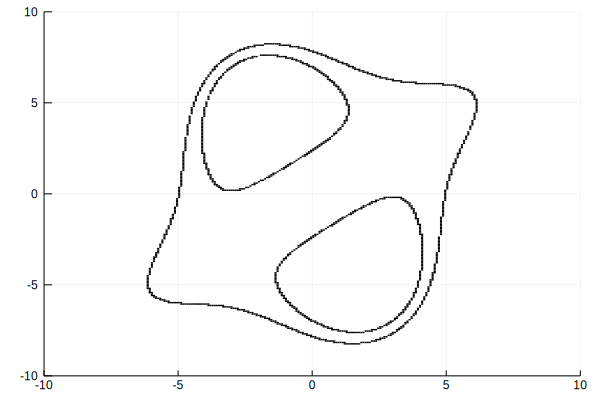

In [7]:
using ImplicitEquations, Plots
gr() # or pyplot()

G = plot()

_Punder(x, y) = sum([Punder.a[i]*x^exponents(mi)[1]* y^exponents(mi)[2] for (i, mi) in enumerate(Punder.x)])
plot!(G, _Punder ⩵ 0., xlims=(-10, 10), ylims=(-10, 10), color="red")

_Pover(x, y) = sum([Pover.a[i]*x^exponents(mi)[1] * y^exponents(mi)[2] for (i, mi) in enumerate(Pover.x)])
plot!(G, _Pover ⩵ 0., xlims=(-10, 10), ylims=(-10, 10), color="blue")

G

In [8]:
G = plot()

_Punder(x, y) = sum([Punder.a[i]*x^exponents(mi)[1]* y^exponents(mi)[2] for (i, mi) in enumerate(Punder.x)])
Gu = plot(_Punder ≪ 0., xlims=(-8, 8), ylims=(-8, 8))

_Pover(x, y) = sum([Pover.a[i]*x^exponents(mi)[1] * y^exponents(mi)[2] for (i, mi) in enumerate(Pover.x)])
Go = plot(_Pover ≪ 0, xlims=(-8, 8), ylims=(-8, 8))

plot(Gu, Go)

### Comparison with a MATLAB/YALMIP implementation

|  Package    | k    |Constraints|Scalar variables|Matrix variables|Time(s)|
|-------------|------|-----------|----------------|----------------|-------|
|JuMP         |    2 |      1017 |            803 |              10|   < 1 |
|YALMIP       |    2 |       152 |             63 |              10|   < 1 |
|JuMP         |    3 |      2871 |           2471 |              10|   ~ 1 |
|YALMIP       |    3 |       254 |            121 |              10|   ~ 1 |
|JuMP         |    4 |      7119 |           6450 |              10|  6.22 |
|YALMIP       |    4 |       394 |           206  |              10|  1.18 |